In [28]:
## Install required libraries
pip install graphviz

In [29]:
## Install library
import xgboost as xg
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error as MSE
from sklearn.preprocessing import LabelEncoder, StandardScaler

%matplotlib inline

In [2]:
## Import datasets
dat_train = pd.read_csv('train.csv')
dat_test = pd.read_csv('test.csv')

In [3]:
## Shape and length of the datasets
print("The lenght of the train dataset is: ", len(dat_train))
print("The lenght of the test dataset is: ", len(dat_test))

print("The shape of the train dataset is: ", dat_train.shape)
print("The shape of the test dataset is: ", dat_test.shape)

The lenght of the train dataset is:  75757
The lenght of the test dataset is:  9705
The shape of the train dataset is:  (75757, 64)
The shape of the test dataset is:  (9705, 63)


In [4]:
## Describe train dataset
dat_train.describe().T.style

,count,mean,std,min,25%,50%,75%,max
Year_Factor,75757.000000,4.367755,1.471441,1.000000,3.000000,5.000000,6.000000,6.000000
floor_area,75757.000000,165983.865858,246875.790940,943.000000,62379.000000,91367.000000,166000.000000,6385382.000000
year_built,73920.000000,1952.306764,37.053619,0.000000,1927.000000,1951.000000,1977.000000,2015.000000
energy_star_rating,49048.000000,61.048605,28.663683,0.000000,40.000000,67.000000,85.000000,100.000000
ELEVATION,75757.000000,39.506323,60.656596,-6.400000,11.900000,25.000000,42.700000,1924.500000
january_min_temp,75757.000000,11.432343,9.381027,-19.000000,6.000000,11.000000,13.000000,49.000000
january_avg_temp,75757.000000,34.310468,6.996108,10.806452,29.827586,34.451613,37.322581,64.758065
january_max_temp,75757.000000,59.054952,5.355458,42.000000,56.000000,59.000000,62.000000,91.000000
february_min_temp,75757.000000,11.720567,12.577272,-13.000000,2.000000,9.000000,20.000000,48.000000
february_avg_temp,75757.000000,35.526837,8.866697,13.250000,31.625000,34.107143,40.879310,65.107143


In [5]:
### Checking NULL values
cols_with_NA = [col for col in dat_train.columns 
                                 if dat_train[col].isnull().any()]
miss_count = dat_train.isna().sum()
miss_df = pd.concat([miss_count.rename('Missing count'), miss_count.div(len(dat_train)).rename('Missing value')],axis = 1).loc[miss_count.ne(0)]
miss_df.style.background_gradient(cmap="coolwarm")

,Missing count,Missing value
year_built,1837,0.024249
energy_star_rating,26709,0.352561
direction_max_wind_speed,41082,0.542287
direction_peak_wind_speed,41811,0.551909
max_wind_speed,41082,0.542287
days_with_fog,45796,0.604512


In [6]:
## Handling missing values
dat_train['year_built'] = dat_train['year_built'].replace(np.nan, dat_train['year_built'].mean())
dat_train['energy_star_rating'] = dat_train['energy_star_rating'].replace(np.nan, dat_train['energy_star_rating'].mean())
dat_train['direction_max_wind_speed'] = dat_train['direction_max_wind_speed'].replace(np.nan, dat_train['direction_max_wind_speed'].median())
dat_train['direction_peak_wind_speed'] = dat_train['direction_peak_wind_speed'].replace(np.nan, dat_train['direction_peak_wind_speed'].median())
dat_train['max_wind_speed'] = dat_train['max_wind_speed'].replace(np.nan, dat_train['max_wind_speed'].median())
dat_train['days_with_fog'] = dat_train['days_with_fog'].replace(np.nan, dat_train['days_with_fog'].median())

dat_test['year_built'] = dat_test['year_built'].replace(np.nan, dat_test['year_built'].mean())
dat_test['energy_star_rating'] = dat_test['energy_star_rating'].replace(np.nan, dat_test['energy_star_rating'].median())
dat_test['direction_max_wind_speed'] = dat_test['direction_max_wind_speed'].replace(np.nan, dat_test['direction_max_wind_speed'].median())
dat_test['direction_peak_wind_speed'] = dat_test['direction_peak_wind_speed'].replace(np.nan, dat_test['direction_peak_wind_speed'].median())
dat_test['max_wind_speed'] = dat_test['max_wind_speed'].replace(np.nan, dat_test['max_wind_speed'].median())
dat_test['days_with_fog'] = dat_test['days_with_fog'].replace(np.nan, dat_test['days_with_fog'].median())

In [7]:
dat_train.describe().T.style

,count,mean,std,min,25%,50%,75%,max
Year_Factor,75757.000000,4.367755,1.471441,1.000000,3.000000,5.000000,6.000000,6.000000
floor_area,75757.000000,165983.865858,246875.790940,943.000000,62379.000000,91367.000000,166000.000000,6385382.000000
year_built,75757.000000,1952.306764,36.601607,0.000000,1927.000000,1952.306764,1976.000000,2015.000000
energy_star_rating,75757.000000,61.048605,23.063738,0.000000,56.000000,61.048605,76.000000,100.000000
ELEVATION,75757.000000,39.506323,60.656596,-6.400000,11.900000,25.000000,42.700000,1924.500000
january_min_temp,75757.000000,11.432343,9.381027,-19.000000,6.000000,11.000000,13.000000,49.000000
january_avg_temp,75757.000000,34.310468,6.996108,10.806452,29.827586,34.451613,37.322581,64.758065
january_max_temp,75757.000000,59.054952,5.355458,42.000000,56.000000,59.000000,62.000000,91.000000
february_min_temp,75757.000000,11.720567,12.577272,-13.000000,2.000000,9.000000,20.000000,48.000000
february_avg_temp,75757.000000,35.526837,8.866697,13.250000,31.625000,34.107143,40.879310,65.107143


In [8]:
## Exclude invalid values
dat_train = dat_train.loc[dat_train['ELEVATION'] > 0]
dat_train = dat_train.loc[dat_train['year_built'] > 0]
dat_train.describe().T.style

,count,mean,std,min,25%,50%,75%,max
Year_Factor,75749.000000,4.367860,1.471404,1.000000,3.000000,5.000000,6.000000,6.000000
floor_area,75749.000000,165983.917673,246887.854872,943.000000,62379.000000,91366.000000,165957.000000,6385382.000000
year_built,75749.000000,1952.461404,32.216240,1600.000000,1927.000000,1952.306764,1976.000000,2015.000000
energy_star_rating,75749.000000,61.048042,23.064794,0.000000,56.000000,61.048605,76.000000,100.000000
ELEVATION,75749.000000,39.508889,60.658843,1.800000,11.900000,25.000000,42.700000,1924.500000
january_min_temp,75749.000000,11.430488,9.379453,-19.000000,6.000000,11.000000,13.000000,49.000000
january_avg_temp,75749.000000,34.308859,6.994642,10.806452,29.827586,34.451613,37.322581,64.758065
january_max_temp,75749.000000,59.053902,5.354585,42.000000,56.000000,59.000000,62.000000,91.000000
february_min_temp,75749.000000,11.718254,12.575772,-13.000000,2.000000,9.000000,20.000000,48.000000
february_avg_temp,75749.000000,35.525083,8.865454,13.250000,31.625000,34.107143,40.879310,65.107143


In [9]:
## Creating a new variable
def building_class_group(d):
    if (d['building_class'] == 'Residential'):
        return 'Residential'
    elif (d['facility_type'] in ('Data_Center', 'Laboratory', 'Grocery_store_or_food_market', 'Health_Care_Inpatient', 'Health_Care_Uncategorized', 'Health_Care_Outpatient_Uncategorized', 'Food_Service_Restaurant_or_cafeteria')):
        return 'Commercial_24_7'
    else:
        return 'Commercial_others'
    
dat_train['building_class_group'] = dat_train.apply(building_class_group, axis=1)
dat_test['building_class_group'] = dat_test.apply(building_class_group, axis=1)
dat_train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,building_class_group
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,0,0,0,1.0,1.0,1.0,104.0,248.682615,0,Commercial_24_7
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,0,0,0,1.0,1.0,1.0,12.0,26.500150,1,Commercial_others
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,0,0,0,1.0,1.0,1.0,12.0,24.693619,2,Commercial_others
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,0,0,0,1.0,1.0,1.0,12.0,48.406926,3,Commercial_others
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,0,0,0,1.0,1.0,1.0,104.0,3.899395,4,Commercial_others


In [10]:
# List all numerical and categorical variables
num = list(dat_train.select_dtypes(include=[np.number]).columns)
print(f'There are {len(num)} numerical columns in the dataset')
cat = list(dat_train.select_dtypes(exclude=[np.number]).columns)
print(f'There are {len(cat)} categorical columns in the dataset')

There are 61 numerical columns in the dataset
There are 4 categorical columns in the dataset


In [11]:
## Standarization - training
scaler = StandardScaler()
scaler.fit(dat_train[num])
x_train_num_st = scaler.transform(dat_train[num])

x_train_num_st = pd.DataFrame(data=x_train_num_st, index=dat_train[num].index, columns=dat_train[num].columns)
x_train_num_st.describe()


,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,7.574900e+04,7.574900e+04,7.574900e+04,7.574900e+04,7.574900e+04,7.574900e+04,7.574900e+04,7.574900e+04,7.574900e+04,7.574900e+04,...,75749.000000,7.574900e+04,7.574900e+04,7.574900e+04,7.574900e+04,7.574900e+04,7.574900e+04,7.574900e+04,7.574900e+04,7.574900e+04
mean,1.680936e-16,-8.704850e-17,4.028244e-15,4.967768e-16,-9.980560e-17,-1.200669e-16,-2.281271e-16,8.404682e-17,1.200669e-16,2.581438e-16,...,0.000000,-6.003345e-17,-6.153428e-17,7.504181e-19,-5.102843e-17,1.230686e-16,-1.005560e-16,1.883549e-16,2.641472e-16,1.560870e-16
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,...,1.000007,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-2.288891e+00,-6.684898e-01,-1.094056e+01,-2.646824e+00,-6.216594e-01,-3.244399e+00,-3.360081e+00,-3.184937e+00,-1.965559e+00,-2.512588e+00,...,-3.272097,-1.285173e+00,-1.239949e-01,-1.718145e-02,-3.173704e-01,-2.993614e-01,-3.140955e-01,-2.940030e+00,-1.400426e+00,-1.732349e+00
25%,-9.296352e-01,-4.196464e-01,-7.903335e-01,-2.188649e-01,-4.551533e-01,-5.789808e-01,-6.406764e-01,-5.703377e-01,-7.727810e-01,-4.399221e-01,...,-0.423682,-7.366037e-01,-1.239949e-01,-1.718145e-02,-3.173704e-01,-2.993614e-01,-3.140955e-01,-6.359566e-02,-4.816195e-01,-8.659860e-01
50%,4.296201e-01,-3.022361e-01,-4.800101e-03,2.444496e-05,-2.391899e-01,-4.589717e-02,2.040918e-02,-1.006652e-02,-2.161515e-01,-1.599410e-01,...,0.051054,-1.880344e-01,-1.239949e-01,-1.718145e-02,-3.173704e-01,-2.993614e-01,-3.140955e-01,-6.359566e-02,-1.251833e-01,1.152423e-05
75%,1.109248e+00,-1.090287e-04,7.306486e-01,6.482632e-01,5.260787e-02,1.673363e-01,4.308643e-01,5.502047e-01,6.585521e-01,6.039469e-01,...,0.565352,2.691067e-01,-1.239949e-01,-1.718145e-02,-3.173704e-01,-2.993614e-01,-3.140955e-01,-6.359566e-02,2.522592e-01,8.660091e-01
max,1.109248e+00,2.519135e+01,1.941226e+00,1.688817e+00,3.107549e+01,4.005538e+00,4.353247e+00,5.966160e+00,2.885070e+00,3.336801e+00,...,7.013848,1.562905e+01,5.272265e+01,1.125430e+02,3.479545e+00,3.582418e+00,4.481632e+00,6.408381e+00,1.571090e+01,1.732007e+00


In [12]:
## New features about temperature
cols_avg = ['january_avg_temp', 'february_avg_temp', 'march_avg_temp', 'april_avg_temp' ,'may_avg_temp', 
        'june_avg_temp', 'july_avg_temp', 'august_avg_temp','september_avg_temp', 'october_avg_temp', 
        'november_avg_temp', 'december_avg_temp']

cols_min = ['january_min_temp', 'february_min_temp', 'march_min_temp', 'april_min_temp' ,'may_min_temp', 
        'june_min_temp', 'july_min_temp', 'august_min_temp','september_min_temp', 'october_min_temp', 
        'november_min_temp', 'december_min_temp']

cols_max = ['january_max_temp', 'february_max_temp', 'march_max_temp', 'april_max_temp' ,'may_max_temp', 
        'june_max_temp', 'july_max_temp', 'august_max_temp','september_max_temp', 'october_max_temp', 
        'november_max_temp', 'december_max_temp']

x_train_num_st['spring_avg'] = (x_train_num_st['march_avg_temp'] + x_train_num_st['april_avg_temp'] + x_train_num_st['may_avg_temp'])/3
x_train_num_st['summe_avg'] = (x_train_num_st['june_avg_temp'] + x_train_num_st['july_avg_temp'] + x_train_num_st['august_avg_temp'])/3
x_train_num_st['fall_avg'] = (x_train_num_st['september_avg_temp'] + x_train_num_st['october_avg_temp'] + x_train_num_st['november_avg_temp'])/3
x_train_num_st['winter_avg'] = (x_train_num_st['december_avg_temp'] + x_train_num_st['january_avg_temp'] + x_train_num_st['february_avg_temp'])/3

x_train_num_st['spring_min'] = (x_train_num_st['march_min_temp'] + x_train_num_st['april_min_temp'] + x_train_num_st['may_min_temp'])/3
x_train_num_st['summe_min'] = (x_train_num_st['june_min_temp'] + x_train_num_st['july_min_temp'] + x_train_num_st['august_min_temp'])/3
x_train_num_st['fall_min'] = (x_train_num_st['september_min_temp'] + x_train_num_st['october_min_temp'] + x_train_num_st['november_min_temp'])/3
x_train_num_st['winter_min'] = (x_train_num_st['december_min_temp'] + x_train_num_st['january_min_temp'] + x_train_num_st['february_min_temp'])/3

x_train_num_st['spring_max'] = (x_train_num_st['march_max_temp'] + x_train_num_st['april_max_temp'] + x_train_num_st['may_max_temp'])/3
x_train_num_st['summe_max'] = (x_train_num_st['june_max_temp'] + x_train_num_st['july_max_temp'] + x_train_num_st['august_max_temp'])/3
x_train_num_st['fall_max'] = (x_train_num_st['september_max_temp'] + x_train_num_st['october_max_temp'] + x_train_num_st['november_max_temp'])/3
x_train_num_st['winter_max'] = (x_train_num_st['december_max_temp'] + x_train_num_st['january_max_temp'] + x_train_num_st['february_max_temp'])/3

In [13]:
x_train_num_st.drop(cols_avg, axis=1, inplace=True)

In [14]:
x_train_num_st.drop(cols_min, axis=1, inplace=True)

In [15]:
x_train_num_st.drop(cols_max, axis=1, inplace=True)
x_train_num_st.head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,...,fall_avg,winter_avg,spring_min,summe_min,fall_min,winter_min,spring_max,summe_max,fall_max,winter_max
0,-2.288891,-0.424252,-0.324727,-2.169903,-0.611768,-2.777375,-1.656542,-2.440918,-1.636202,-0.940688,...,0.546192,1.772467,1.251462,-1.283532,1.33882,1.980785,-0.564257,-1.665219,0.027887,1.490062
1,-2.288891,0.437514,0.078799,-0.695785,-0.621659,-2.777375,-1.656542,-2.440918,-1.636202,-0.940688,...,0.546192,1.772467,1.251462,-1.283532,1.33882,1.980785,-0.564257,-1.665219,0.027887,1.490062
2,-2.288891,0.461918,-0.045363,1.558748,-0.621659,-2.777375,-1.656542,-2.440918,-1.636202,-0.940688,...,0.546192,1.772467,1.251462,-1.283532,1.33882,1.980785,-0.564257,-1.665219,0.027887,1.490062
3,-2.288891,-0.448218,0.854810,-0.652429,-0.621659,-2.777375,-1.656542,-2.440918,-1.636202,-0.940688,...,0.546192,1.772467,1.251462,-1.283532,1.33882,1.980785,-0.564257,-1.665219,0.027887,1.490062
4,-2.288891,-0.404980,1.010013,1.688817,-0.611768,-2.777375,-1.656542,-2.440918,-1.636202,-0.940688,...,0.546192,1.772467,1.251462,-1.283532,1.33882,1.980785,-0.564257,-1.665219,0.027887,1.490062


In [16]:
## Correlation
dat_corr = x_train_num_st.corr()
corr_target= pd.DataFrame(dat_corr['site_eui'].sort_values(ascending= True))
corr_target

,site_eui
energy_star_rating,-0.379168
winter_avg,-0.159550
winter_min,-0.154129
spring_min,-0.108871
avg_temp,-0.089129
spring_avg,-0.088558
winter_max,-0.080037
fall_min,-0.061129
days_above_100F,-0.049964
spring_max,-0.046978


In [17]:
data_sub1 = corr_target.loc[corr_target['site_eui'] <= -0.1]
data_sub1


,site_eui
energy_star_rating,-0.379168
winter_avg,-0.159550
winter_min,-0.154129
spring_min,-0.108871


In [18]:
data_sub2 = corr_target.loc[corr_target['site_eui'] >= 0.1]
data_sub2

,site_eui
snowdepth_inches,0.113347
precipitation_inches,0.113508
days_below_20F,0.119463
cooling_degree_days,0.125064
summe_avg,0.131362
days_below_30F,0.139781
heating_degree_days,0.147822
snowfall_inches,0.157254
site_eui,1.000000


In [19]:
covs_selected = ['energy_star_rating', 'winter_avg', 'winter_min', 'spring_min', 'snowdepth_inches','precipitation_inches' ,'days_below_20F', 
                 'cooling_degree_days', 'summe_avg', 'days_below_30F', 'heating_degree_days', 'snowfall_inches']

new_dataset_train = x_train_num_st[covs_selected]
target = dat_train['site_eui']
new_dataset_train.head(20)

,energy_star_rating,winter_avg,winter_min,spring_min,snowdepth_inches,precipitation_inches,days_below_20F,cooling_degree_days,summe_avg,days_below_30F,heating_degree_days,snowfall_inches
0,-2.169903,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202
1,-0.695785,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202
2,1.558748,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202
3,-0.652429,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202
4,1.688817,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202
5,0.000024,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202
6,-0.218865,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202
7,1.645461,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202
8,1.602104,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202
9,0.951758,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202


In [20]:
var_cat = dat_train[cat]
var_cat

,State_Factor,building_class,facility_type,building_class_group
0,State_1,Commercial,Grocery_store_or_food_market,Commercial_24_7
1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,Commercial_others
2,State_1,Commercial,Retail_Enclosed_mall,Commercial_others
3,State_1,Commercial,Education_Other_classroom,Commercial_others
4,State_1,Commercial,Warehouse_Nonrefrigerated,Commercial_others
...,...,...,...,...
75752,State_11,Commercial,Office_Uncategorized,Commercial_others
75753,State_11,Residential,5plus_Unit_Building,Residential
75754,State_11,Commercial,Commercial_Other,Commercial_others
75755,State_11,Commercial,Commercial_Other,Commercial_others


In [36]:
## Working with categorical data
labelencoder = LabelEncoder()
new_dataset_train['new_state_factor'] = labelencoder.fit_transform(var_cat['State_Factor'])
new_dataset_train['new_building_class_group'] = labelencoder.fit_transform(var_cat['building_class_group'])
new_dataset_train['new_facility_type'] = labelencoder.fit_transform(var_cat['facility_type'])
new_dataset_train.head(20)
##var_cat.tail()

C:\Users\neliq\AppData\Local\Temp/ipykernel_16996/4217412600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataset_train['new_state_factor'] = labelencoder.fit_transform(var_cat['State_Factor'])
C:\Users\neliq\AppData\Local\Temp/ipykernel_16996/4217412600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataset_train['new_building_class_group'] = labelencoder.fit_transform(var_cat['building_class_group'])
C:\Users\neliq\AppData\Local\Temp/ipykernel_16996/4217412600.py:5: SettingWithCopyWarn

,energy_star_rating,winter_avg,winter_min,spring_min,snowdepth_inches,precipitation_inches,days_below_20F,cooling_degree_days,summe_avg,days_below_30F,heating_degree_days,snowfall_inches,new_state_factor,new_building_class_group,new_facility_type
0,-2.169903,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202,0,0,13
1,-0.695785,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202,0,1,55
2,1.558748,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202,0,1,48
3,-0.652429,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202,0,1,6
4,1.688817,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202,0,1,56
5,0.000024,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202,0,1,58
6,-0.218865,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202,0,1,56
7,1.645461,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202,0,1,56
8,1.602104,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202,0,1,32
9,0.951758,1.772467,1.980785,1.251462,-0.940688,-2.440918,-1.206007,-2.777375,-3.513231,-1.76766,-1.656542,-1.636202,0,1,32


In [ ]:
# Export for further feature selection
new_dataset_train.to_csv('train_new2.csv', encoding='utf-8', header=True) 

In [22]:
# Splitting
data_dmatrix = xg.DMatrix(data=new_dataset_train,label=target)
train_X, test_X, train_y, test_y = train_test_split(new_dataset_train, target,
                      test_size = 0.3, random_state = 123)

In [37]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
cv_results = xg.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [38]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,93.491196,0.524754,93.496269,1.135138
1,87.288757,0.448393,87.288551,1.365728
2,81.608315,0.448392,81.641795,1.380793
3,76.973923,0.400376,77.012123,1.591683
4,72.799289,0.652482,72.834066,1.801312


In [35]:
print(cv_results["test-rmse-mean"])

0     93.496269
1     87.288551
2     81.641795
3     77.012123
4     72.834066
5     69.219460
6     66.128996
7     63.326392
8     61.372041
9     59.576102
10    57.719325
11    56.262786
12    55.011639
13    54.041073
14    53.298588
15    52.512745
16    51.922999
17    51.292506
18    50.814634
19    50.424530
20    49.833647
21    49.377843
22    49.095959
23    48.776526
24    48.687923
25    48.407204
26    48.256048
27    48.114763
28    48.035648
29    47.942155
30    47.772916
31    47.647842
32    47.559292
33    47.458972
34    47.230624
35    47.145179
36    47.087096
37    47.006733
38    46.956430
39    46.883287
40    46.798892
41    46.769375
42    46.652253
43    46.523913
44    46.440952
45    46.358061
46    46.352414
47    46.330240
48    46.278538
49    46.239278
Name: test-rmse-mean, dtype: float64


In [34]:
xg_reg = xg.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
print(xg_reg)

[08:26:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


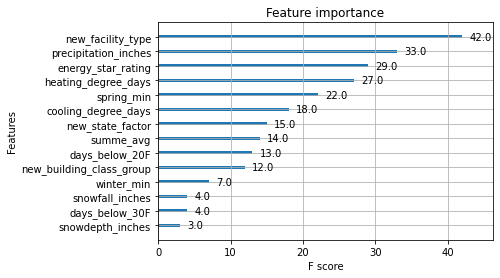

In [32]:
## Feature importance
xg.plot_importance(xg_reg)
plt.show()